In [ ]:
import datetime as dt
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
plt.close('all')
import yfinance as yf
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
sq_1d = yf.download(tickers='SQ', start='2019-09-01', end = '2021-08-11', interval='1d')
sq_1d.drop(columns = ['Open','High','Low','Adj Close','Volume'], inplace = True)
# sq_1d.reset_index(inplace=True)
# sq_1d.rename(columns = {'index':'Datetime'}, inplace = True)
# sq_1d.set_index(pd.to_datetime(sq_1d['Datetime'],infer_datetime_format=True),inplace=True)
sq_1d.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2019-09-03,61.130001
2019-09-04,61.169998
2019-09-05,63.020000
2019-09-06,62.000000
2019-09-09,61.470001


In [ ]:
sq_diff = sq_1d['Close'].diff()
up = sq_diff.clip(lower=0)
down = -1*sq_diff.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
rs

Date
2019-09-03         NaN
2019-09-04        -inf
2019-09-05        -inf
2019-09-06    2.157530
2019-09-09    1.383408
                ...   
2021-08-04    1.505334
2021-08-05    1.990352
2021-08-06    1.621160
2021-08-09    1.758997
2021-08-10    1.449879
Name: Close, Length: 489, dtype: float64

In [ ]:
sq_1d['RSI'] = 100 - (100/(1 + rs))
sq_1d['RSI'] 

Date
2019-09-03           NaN
2019-09-04    100.000000
2019-09-05    100.000000
2019-09-06     68.329674
2019-09-09     58.043269
                 ...    
2021-08-04     60.085156
2021-08-05     66.559125
2021-08-06     61.848951
2021-08-09     63.754948
2021-08-10     59.181652
Name: RSI, Length: 489, dtype: float64

In [ ]:

#sq_1hr['RSI’]
sq_1d_rsi= sq_1d.iloc[: , 1:]
sq_1d_rsi

,RSI
Date,
2019-09-03,NaN
2019-09-04,100.000000
2019-09-05,100.000000
2019-09-06,68.329674
2019-09-09,58.043269
...,...
2021-08-04,60.085156
2021-08-05,66.559125
2021-08-06,61.848951


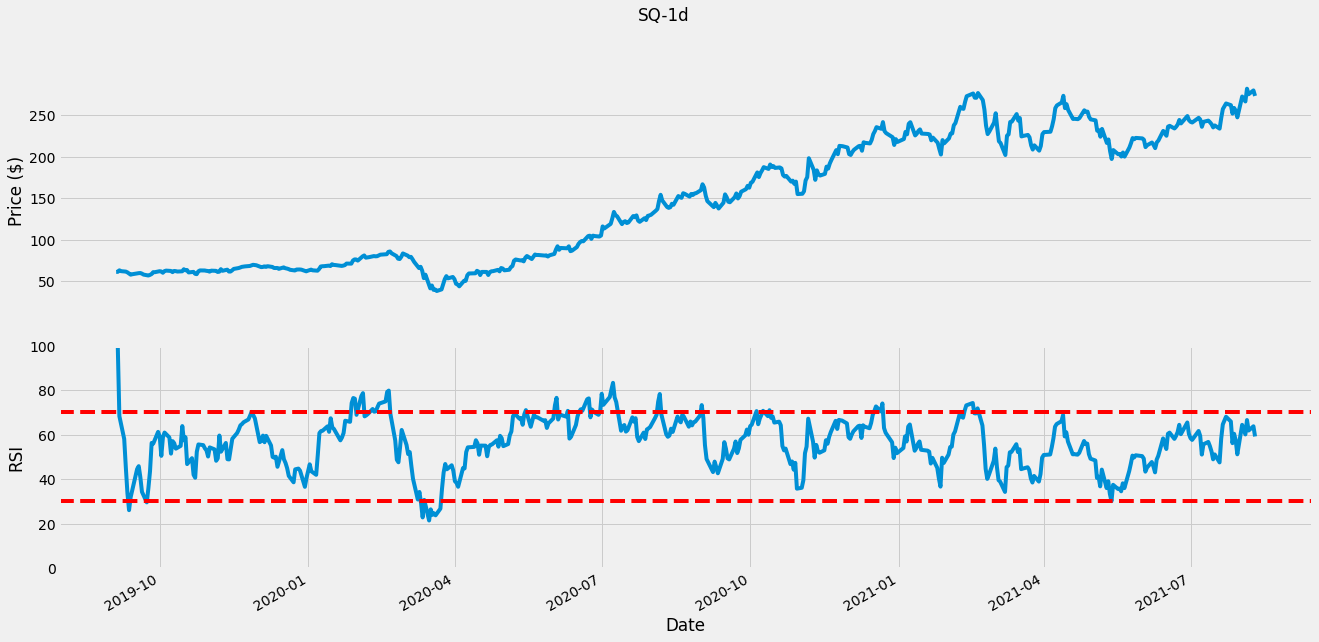

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.get_xaxis().set_visible(False)
fig.suptitle('SQ-1d')
sq_1d['Close'].plot(ax=ax1)

ax1.set_ylabel('Price ($)')
sq_1d['RSI'].plot(ax=ax2)
ax2.set_ylim(0,100)
ax2.axhline(30, color= 'r', linestyle= '--')
ax2.axhline(70, color= 'r', linestyle= '--')
ax2.set_ylabel('RSI')
plt.show()

In [ ]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 40 and rsi[i] < 40:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(sq_1d['Close'], sq_1d_rsi['RSI'])

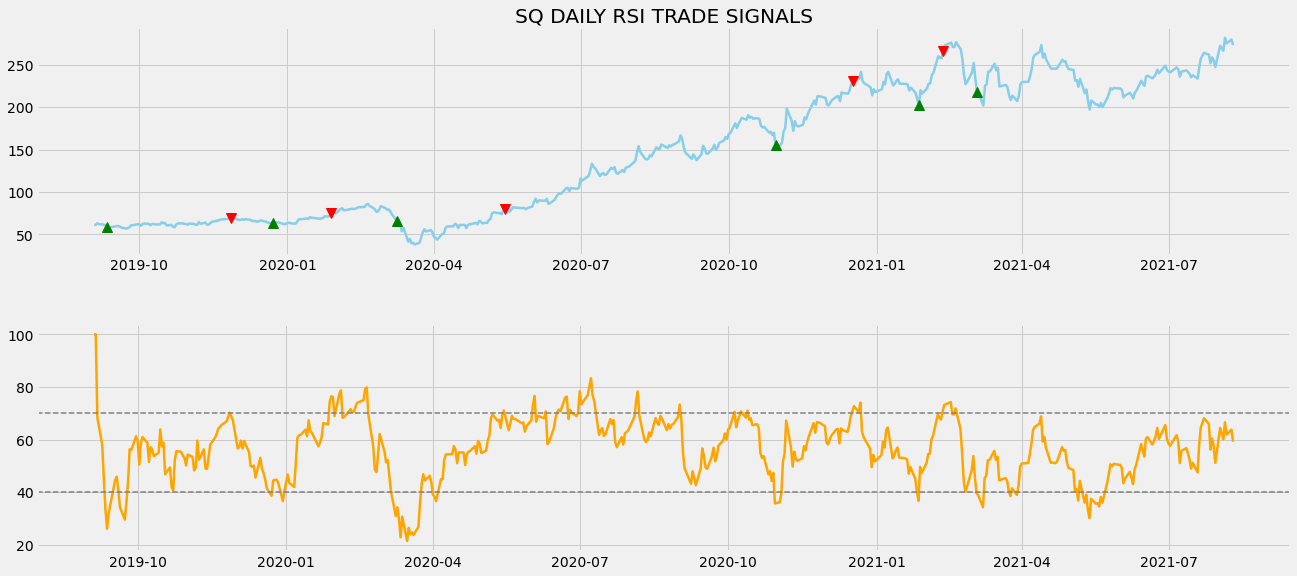

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(sq_1d['Close'], linewidth = 2.5, color = 'skyblue', label = 'SQ')
ax1.plot(sq_1d.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(sq_1d.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('SQ DAILY RSI TRADE SIGNALS')
ax2.plot(sq_1d['RSI'], color = 'orange', linewidth = 2.5)
ax2.axhline(40, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [ ]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(sq_1d['Close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = sq_1d_rsi['RSI']
close_price = sq_1d['Close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(sq_1d.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(sq_1d.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,RSI,rsi_signal,rsi_position
Date,,,,
2019-09-03,61.130001,NaN,0,1
2019-09-04,61.169998,100.000000,0,1
2019-09-05,63.020000,100.000000,0,1
2019-09-06,62.000000,68.329674,0,1
2019-09-09,61.470001,58.043269,0,1
...,...,...,...,...
2021-08-04,266.420013,60.085156,0,1
2021-08-05,281.809998,66.559125,0,1
2021-08-06,275.100006,61.848951,0,1


In [ ]:
sq_1d_rsi_ret = pd.DataFrame(np.diff(sq_1d['Close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(sq_1d_rsi_ret)):
    returns = sq_1d_rsi_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/sq_1d['Close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in SQ : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))


Profit gained from the RSI strategy by investing $100k in SQ : 83832.29
Profit percentage of the RSI strategy : 83%


In [ ]:
strategy.to_csv('SQ 1D RSI TRADE STRATEGY.csv')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>